In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
def load_data(directory, img_size, num_classes=60):
    all_arrays = []
    classes = []
    for i in os.listdir(directory):
        path = os.path.join(directory, i)
        if os.path.isdir(path):
            if num_classes is not None and len(classes) >= num_classes:
                break
            classes.append(i)
            class_num = classes.index(i)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    all_arrays.append([img_array, class_num])
                except Exception as e:
                    print(f"Error processing image: {img}, {e}")
    return all_arrays, classes


img_size = 100

train_directory = "../input/fruits-360_dataset/fruits-360/Training"
train_all_arrays, classes = load_data(train_directory, img_size)

test_directory = "../input/fruits-360_dataset/fruits-360/Test"
test_all_arrays, _ = load_data(test_directory, img_size)  




/Users/resyurika/Desktop/CNN-fruits-classification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


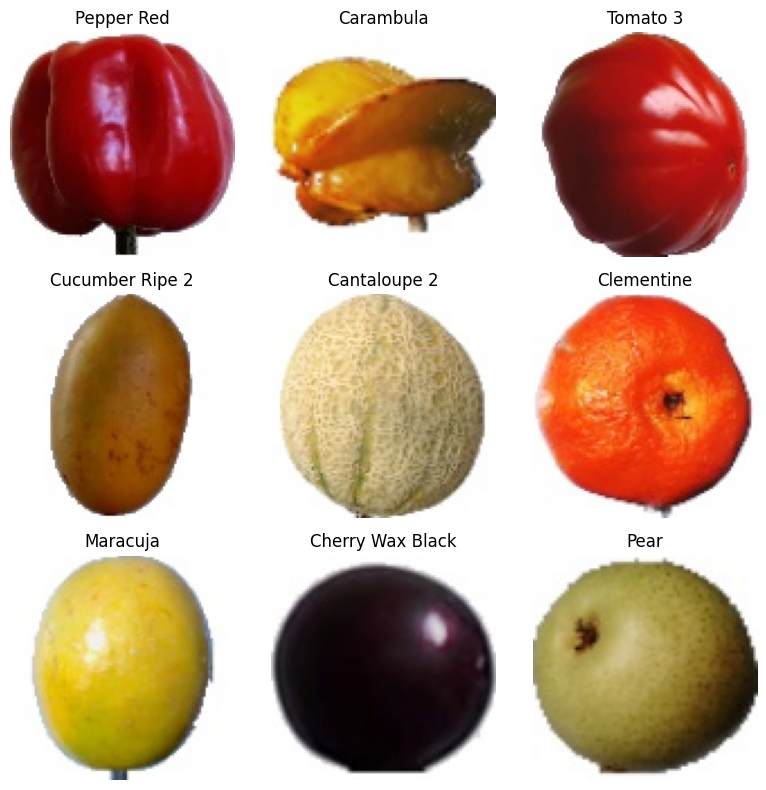

In [2]:
def display_images_by_class(data, classes, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    axes = axes.flatten()

    # Select 9 random classes
    selected_classes = random.sample(classes, 9)
    
    # Select a random image from each class
    class_indices = {c: [] for c in selected_classes}
    for i, (img, label) in enumerate(data):
        if classes[label] in selected_classes:
            class_indices[classes[label]].append(i)

    for i, class_name in enumerate(selected_classes):
        # Select a random image from the class
        img_index = np.random.choice(class_indices[class_name])
        img, label = data[img_index]
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

display_images_by_class(train_all_arrays, classes, 3, 3)

In [3]:
# Shuffle the training data
np.random.shuffle(train_all_arrays)

# Create training data arrays
X_train = np.array([features for features, label in train_all_arrays])
Y_train = np.array([label for features, label in train_all_arrays])

# Shuffle the test data
np.random.shuffle(test_all_arrays)

# Create test data arrays
X_test = np.array([features for features, label in test_all_arrays])
Y_test = np.array([label for features, label in test_all_arrays])


In [4]:
#normalization and reshaping
X_train=X_train.reshape(-1,img_size,img_size,3)
X_train=X_train / 255
X_test=X_test.reshape(-1,img_size,img_size,3)
X_test=X_test / 255


In [5]:
Y_train=to_categorical(Y_train,num_classes=len(classes))
Y_test=to_categorical(Y_test,num_classes=len(classes))


In [6]:
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train,test_size=0.2,random_state=50)

In [7]:
# Defining the model 
# The model is using 3 layer convolution neural network with 8, 16 and 64 filters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras import Input

model = Sequential()
model.add(Input(shape=(100, 100, 3)))

model.add(Conv2D(filters=8, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation="softmax"))

# Defining optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        25,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │        30,780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,779,372 (18.23 MB)

 Trainable params: 4,779,372 (18.23 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Data augmentation

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)


In [9]:
import warnings
warnings.filterwarnings("ignore")
epochs = 10
batch_size = 32
# Model fitting using `fit` method
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    
    validation_data=(x_val, y_val),
    steps_per_epoch=x_train.shape[0] // batch_size
)

Epoch 1/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.3376 - loss: 2.4164 - val_accuracy: 0.8789 - val_loss: 0.3501
Epoch 2/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8414 - loss: 0.4747 - val_accuracy: 0.9391 - val_loss: 0.1984
Epoch 3/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.8772 - loss: 0.3567 - val_accuracy: 0.9811 - val_loss: 0.0725
Epoch 4/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9121 - loss: 0.2613 - val_accuracy: 0.9865 - val_loss: 0.0525
Epoch 5/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.9314 - loss: 0.1935 - val_accuracy: 0.9954 - val_loss: 0.0253
Epoch 6/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9402 - loss: 0.1741 - val_accuracy: 0.9916 - val_loss: 0.0317
Epoch 7/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.9465 - loss: 0.1546 - val_accuracy: 0.9973 - val_loss: 0.0132
Epoch 8/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9578 - loss: 0.1301 - val

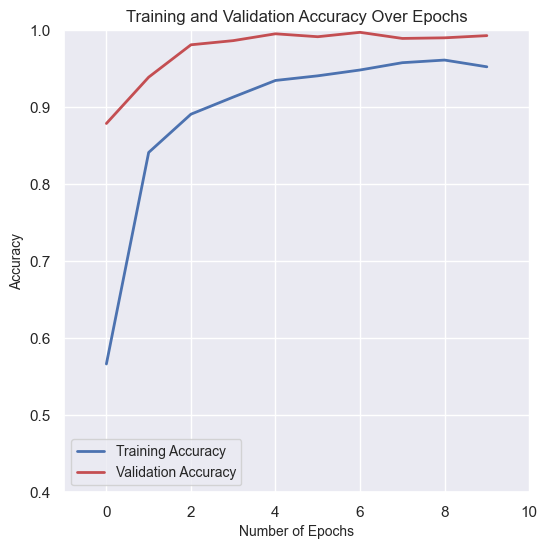

In [25]:

import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn's style
sns.set_theme()

plt.figure(figsize=(6,6)) # set the size of the figure
plt.plot(history.history["accuracy"], color="b", label="Training Accuracy",linewidth=2)
plt.plot(history.history["val_accuracy"], color="r", label="Validation Accuracy",linewidth=2)
plt.title("Training and Validation Accuracy Over Epochs", fontsize=12)
plt.xlabel("Number of Epochs", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.grid(True)
plt.ylim(0.4, 1)
plt.legend(fontsize=10)
plt.xlim(-1, 10)
# Remove top and right borders
sns.despine()

plt.show()



197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


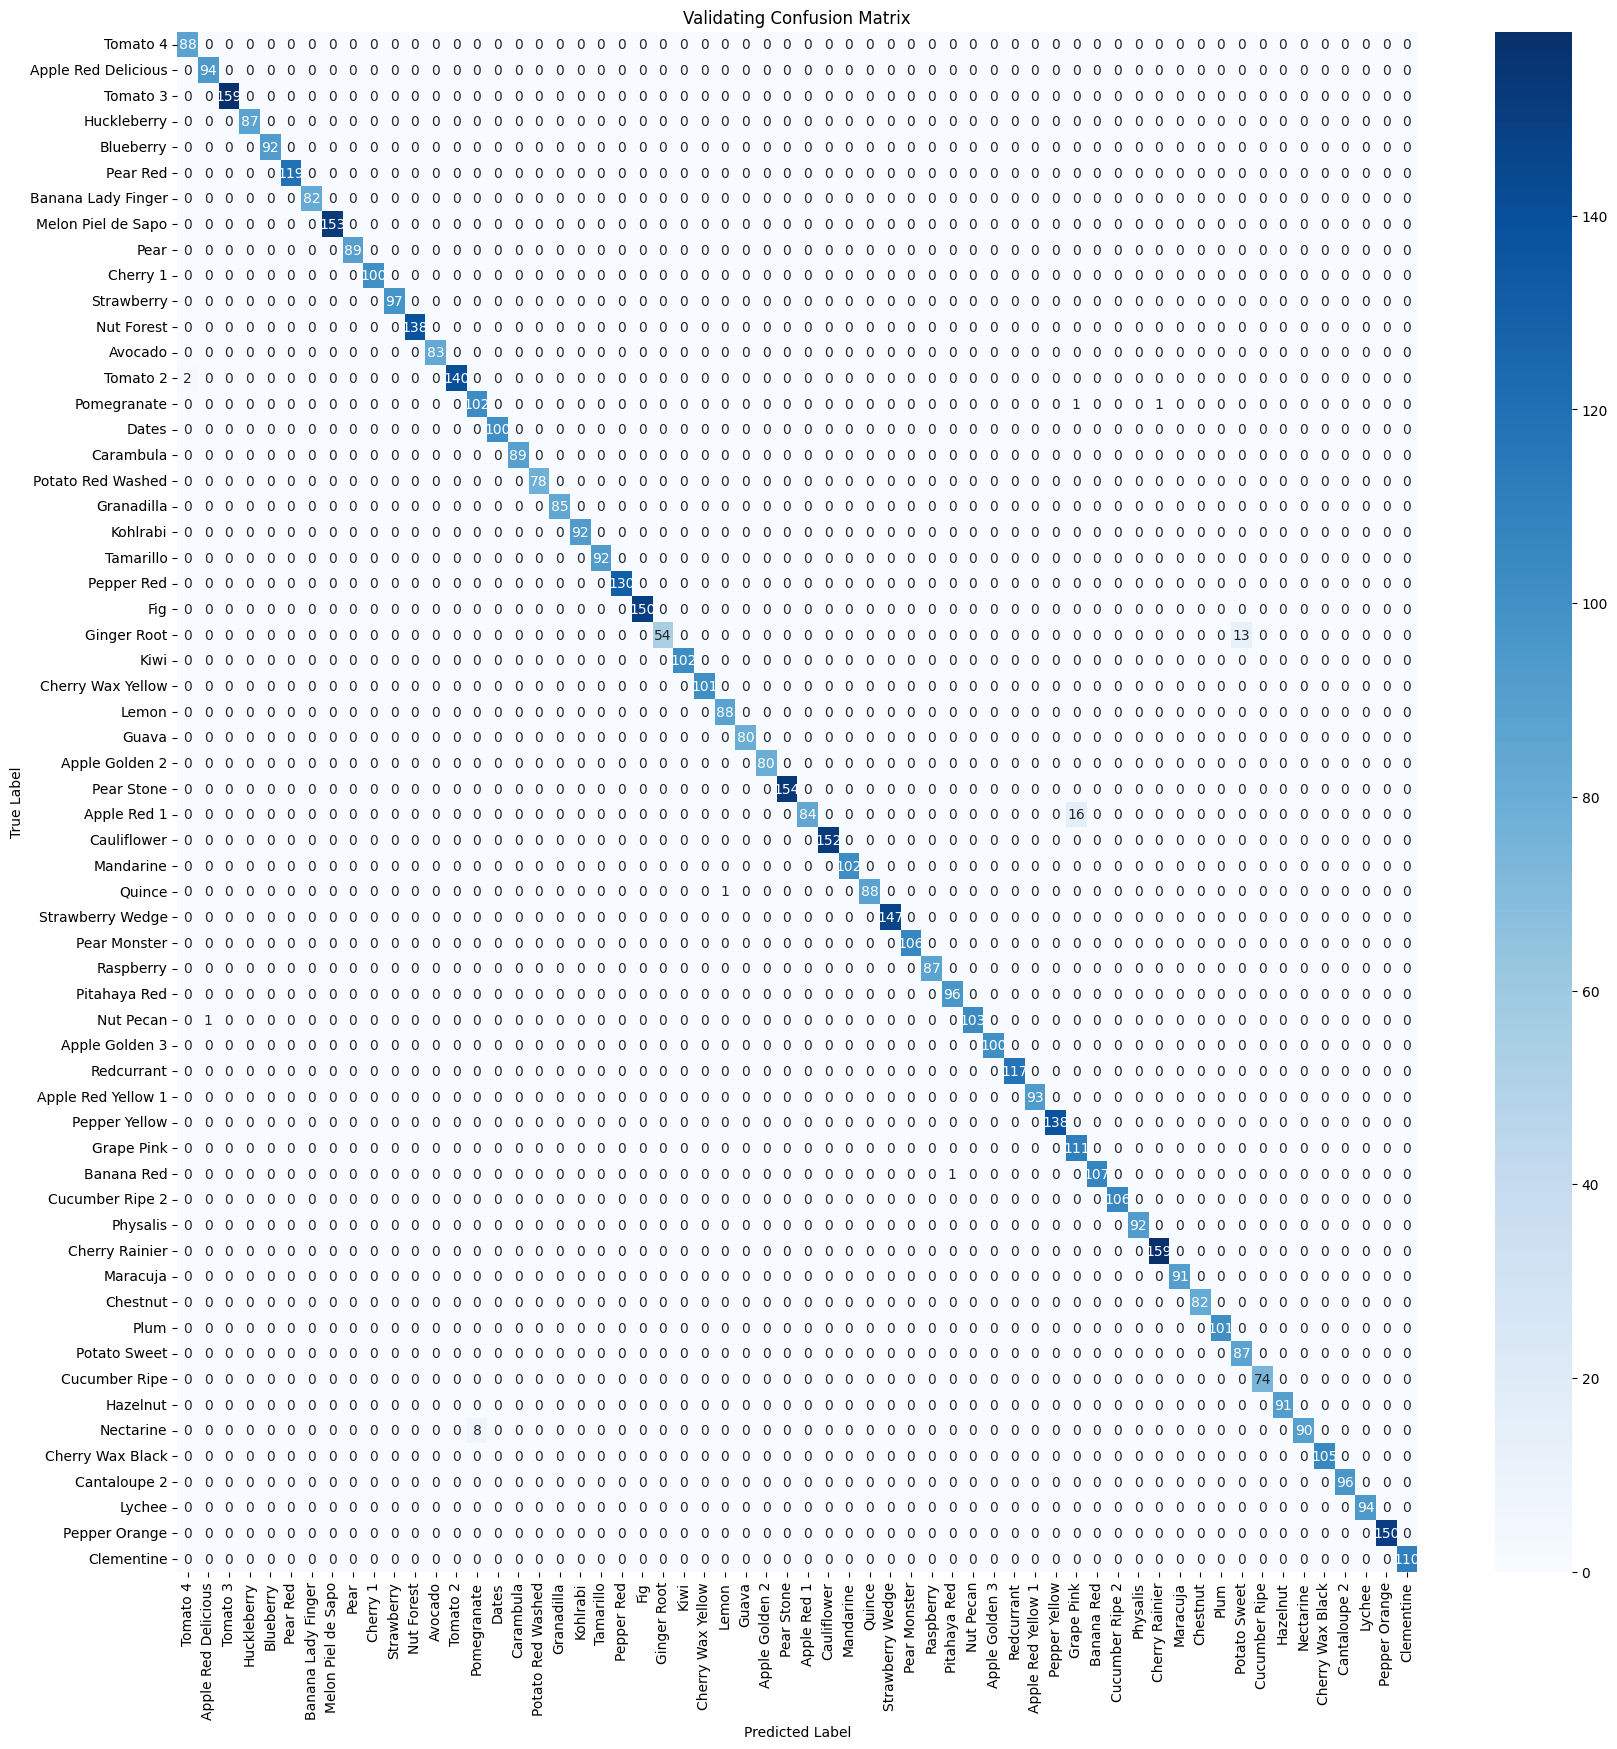

In [11]:

# Model evaluation: confusion matrix
from sklearn.metrics import confusion_matrix
# Plot validating confusion matrix
y_pred=model.predict(x_val)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_val,axis=1)
conf_mat=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Validating Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


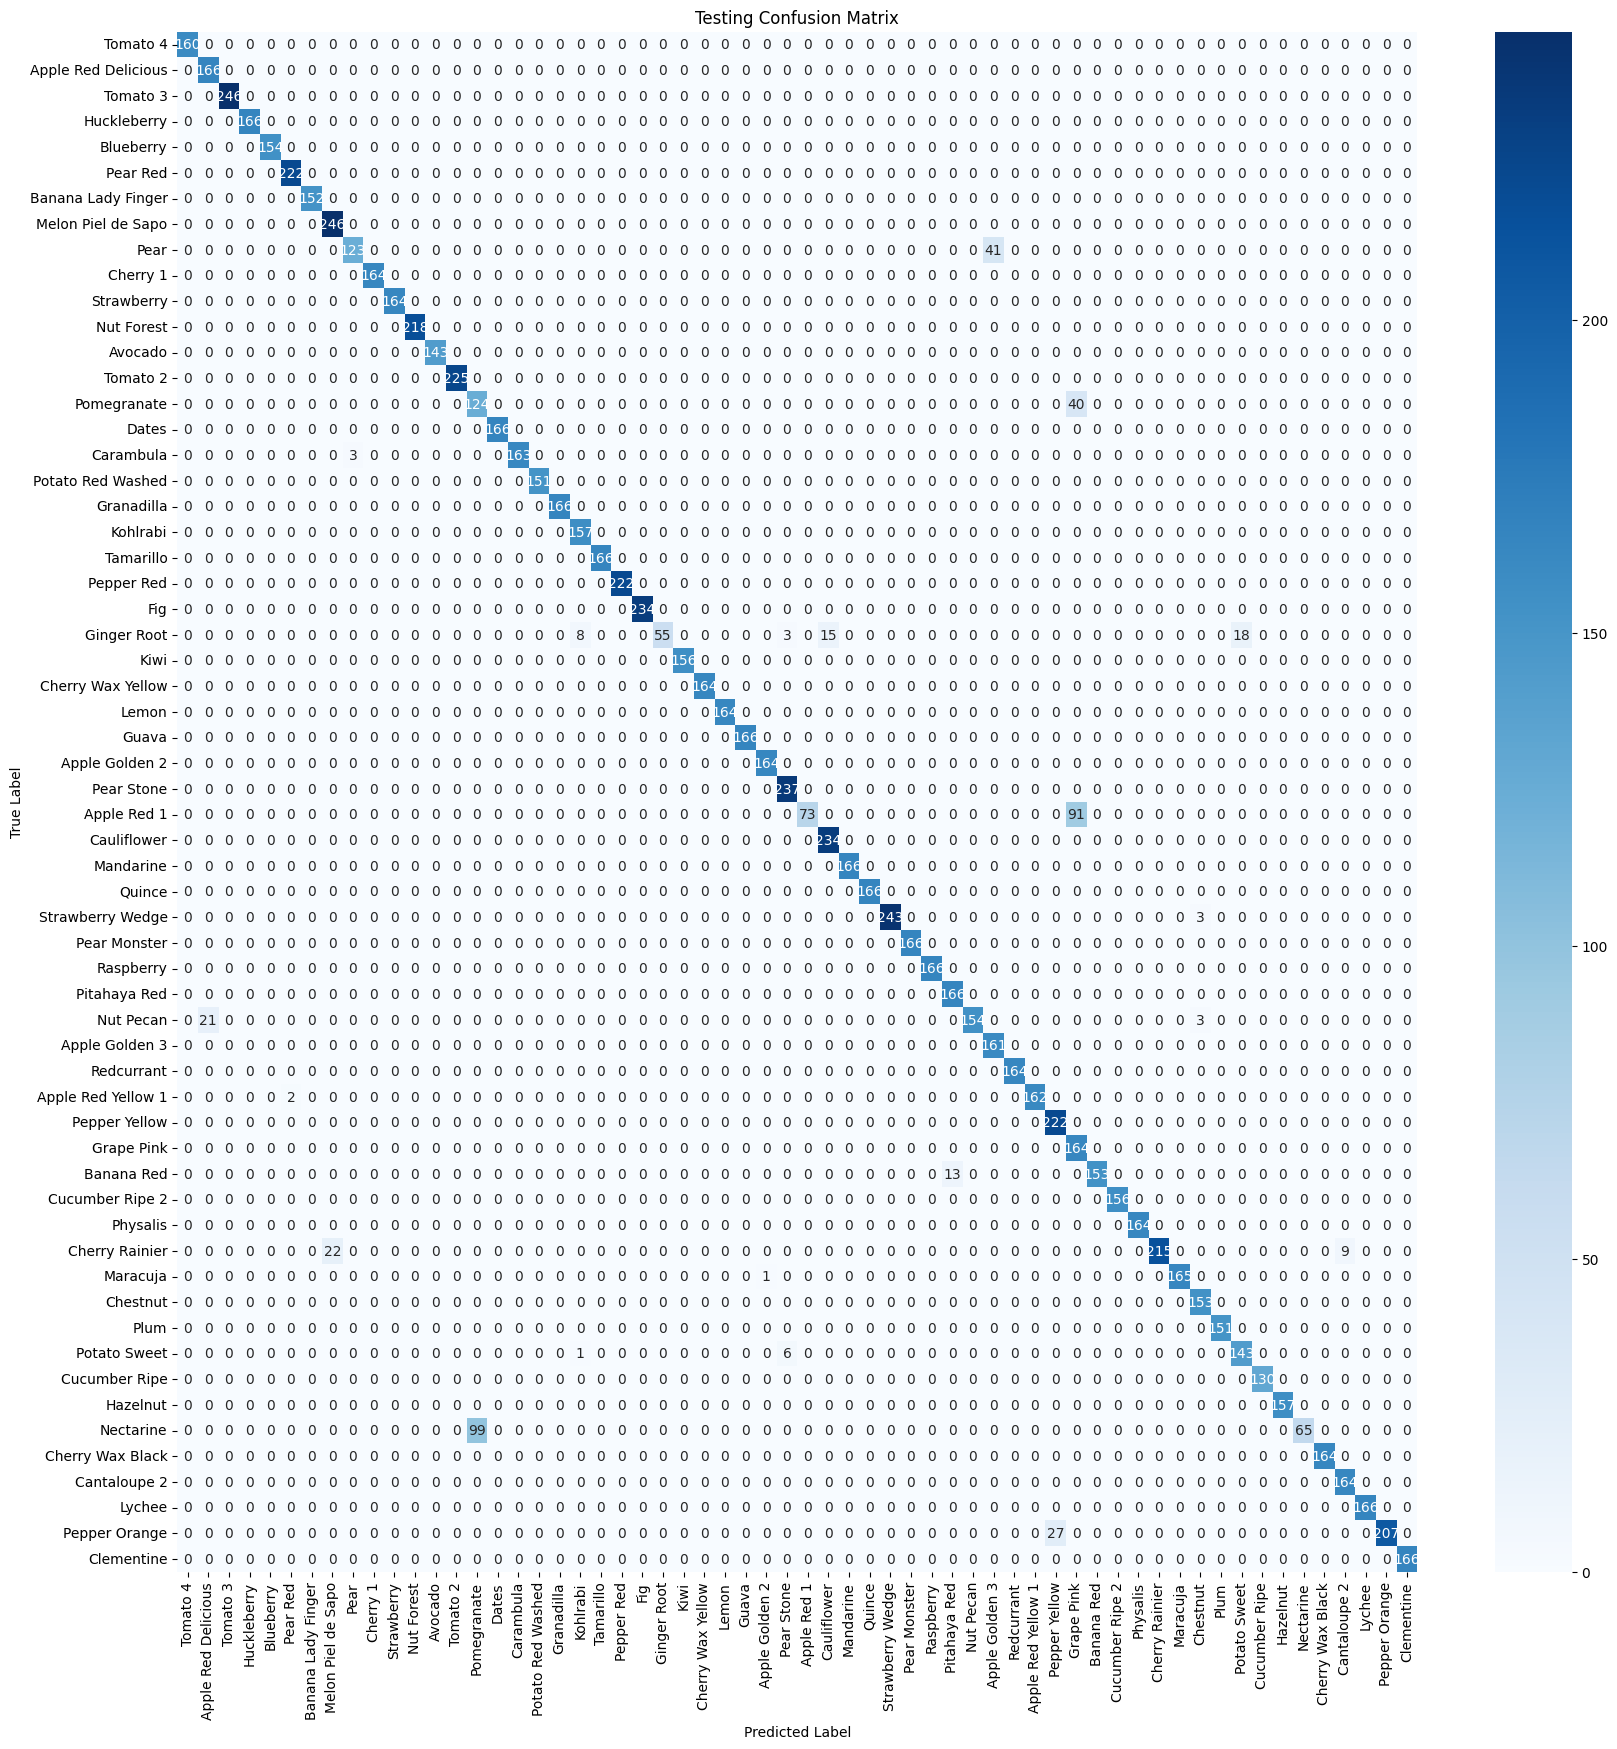

In [12]:
# Plot Testing confusion matrix
y_pred2=model.predict(X_test)
y_pred_classes2=np.argmax(y_pred2,axis=1)
y_true2=np.argmax(Y_test,axis=1)
#compute conf mat
conf_mat2=confusion_matrix(y_true2,y_pred_classes2)
plt.figure(figsize=(20,20))
sns.heatmap(conf_mat2, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Testing Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [13]:
results = model.evaluate(X_test, Y_test, batch_size=64)

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9620 - loss: 0.1208


In [14]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('\nTest accuracy:', test_acc)


330/330 - 4s - 12ms/step - accuracy: 0.9596 - loss: 0.1148

Test accuracy: 0.9596437811851501


In [15]:
# model.save("model.h5")